## library, parameter setting and initalization

integrator.py and analysis.py are costume library by John!

- integrator tasks for solving Poisson-Jeans equation and low level jobs (e.g. fitting, integration, etc.)

- analysis tasks for mid-level analysis handling

In [1]:
import numpy as np
import scipy.integrate as nint
import scipy.interpolate as interp
import scipy.stats as stats
import matplotlib.pyplot as plt
from tqdm import tqdm
import integrator as intt
import analysis as an

%matplotlib inline

raw_gridFile - **output** exclusion grid points before 2D fitting

gridFile - **output** exclusion *rectangular* grid points after 2D fitting

starFile - **input** density profile (format generated by gaia_cut_2.py)

starWFile - **input** mid-plane velocity profile (format generated by gaia_cut_2.py)

In [18]:
gridFile = '/Users/john/Desktop/john_code/DarkDisk/gridGStarCorr.txt'
raw_gridFile = '/Users/john/Desktop/john_code/DarkDisk/gridGStarCorr_raw.txt'
starFile = '/Users/john/Desktop/john_code/DarkDisk/G_stars.txt'
starWFile = '/Users/john/Desktop/john_code/DarkDisk/G_stars_w_midplane.txt'

From top to bottom:

*delw* : w velocity integration step size

*delz* : z spatial integration step size

*zRangeLarge* : Poisson Jeans solver solution in z-space spanned by $\Phi(z)$

*zRangeMed* : the z-space of interest spanned by the tracer density $\rho(z)$ predicted from $\Phi(z)$. (zRangeMed $\subset$ zRangeLarge) 

*zRangeRed* : z-space of interest for the final likelihood calculation (zRangeRed $\subset$ zRangeMed)

*nBootstrapSample* : number of Bootstrap samples used (not necessary)

*l_range_p/n* : upper/lower range for the likelihood calculation in z-bins

*nStars* : extract the total number of stars in the data file. (to be used with bootstrap statistics)

In [19]:
delw = 0.01
delz = 20.
zRangeLarge = 2600.
zRangeMed = 300.
zRangeRed = 260.
nBootstrapSample = 20
l_range_p = 220.
l_range_n = -220.

nStars = len(np.loadtxt(starFile, delimiter= ",", skiprows=1, usecols=(0), unpack=True))

zspace = np.linspace(0., zRangeRed, int(zRangeRed/delz))
zspaceMed = np.linspace(0., zRangeMed, int(zRangeMed/delz))
zspaceFull  = np.linspace(-zRangeRed, zRangeRed, 2*int(zRangeRed/delz)-1)
zspaceLarge  = np.linspace(-zRangeLarge, zRangeLarge, 2*int(zRangeLarge/delz)-1)

## Gaia data handling

fetchWDist_gaia: get the w velocity profile, fit it to a normalized gaussian and bin it according to a wspace (defined in a subroutine in analysis.py). The argument is the file path as a string. Can print fitted parameters as an option (verbose = True).

*fetchZDistHist* : get the z-space tracer star density profile $\rho_{\text{obs}}(z)$ from Gaia data set and bin it according to a user defined z-space bins (zspaceFull). Outputting the binned density profiles in an array. Arguments:

-    starFile - string. Path to the density profile.
-    zspaceFull - np.linspace. Previously defined.
-    use_evfs - whether to use Bovy's evfs (should be stored in starFile). If false, evfs weight = 1.
-    show_plot - plot the density profile.

('Best-fit velocity sigma = ', array([ 14.77305096]), ' +/- ', array([[ 0.40846155]]))


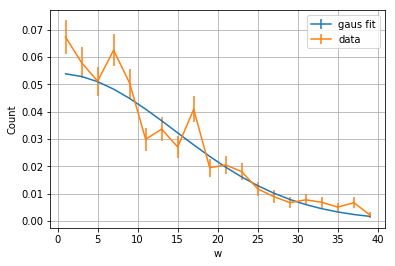

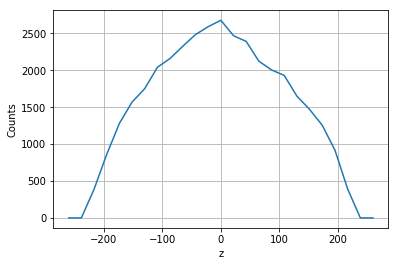

In [20]:
wspace, wfunct = an.fetchWDist_gaia(starWFile, verbose=True, show_plot=True)
starDensity = an.fetchZDistHist(starFile, zspaceFull, use_evfs = True, show_plot = True)

*SDDensity* : The $\sqrt{n}$ error of the density data. (which is than normalized because the error must not contain the evfs weight, but the physical density must.)

*starDensity_norm* : used to normalize the density profile in the data. Here we set the central bin height to unity as normalization (Normalization with midplane density).

interp{x/y/z} are empty arrays initialized for latter to be appended with exclusion plot grid point data. (x for $\Sigma_D$, y for $h_D$ and z for the log-likelihood)

In [21]:
SDDensity = np.sqrt(an.fetchZDistHist(starFile, zspaceFull, use_evfs = False))
for i, sd in enumerate(SDDensity):
   if sd == 0:
      SDDensity[i] = 1.
   else:
      SDDensity[i] = starDensity[i]/sd
starDensity_norm = starDensity[int(np.ceil(len(starDensity)/2.))]
starDensity = starDensity/starDensity_norm
starDensity_Delta = SDDensity/starDensity_norm

interpz = []
interpy = []
interpx = []
interpxy = []

## Poisson-Jeans Prediction Handling

$\Sigma_D=0$ is a special point, since **1.)** physically its equivalent to no Dark Disk; **2)** all $h_D$ values collapse to a single point (like the $\theta$ coordinate when $r=0$ in polar corrdinates); **3)** *0* generally gives computer program problems if not handled properly (such as division by zero). Therefore we will treat it separately. It best serves as an example for the later loops over the parameter space.

Ignore the "zero_" prefix, which will be dropped later in the full parameter loops. The flow of the program is as follow: 
<newline>
<center>solu - storing the *potential $\Phi(z)$* solution for Poisson-Jeans equation giving the $\Sigma_D$ and $h_D$, and the internal set baryonic/DM Halo densities.</center>

<center>$\downarrow$</center>

<center>predict - convert the $\Phi(z)$ prediction to the tracer density $\rho(z)$ prediction</center>

<center>$\downarrow$</center>

<center>SDPredict - find the uncertainty of the prediction. Set uncertainty to *0* at the moment (to be incorporated with prediction uncertainty soon)</center>

<center>$\downarrow$</center>

<center>Normalize densities by the midplane density</center>

<center>$\downarrow$</center>

<center> Calculate the Likelihood function </center>
<newline>
We then proceed to, using a for loop, set the whole $\Sigma_D=0$ axis to the output likelihood value, since their value should be the same. We now have a set of likelihood along the $\Sigma_D=0$ strip!

Here is the list of functions used:
- *PoissonJeansSolve* : Solve the Poisson-Jeans solution for the gravitational potential $\Phi(z)$ and output the potential in the user-specified range of space "zRangeLarge". Output format is smooth interpolated function (return type of scipy.interpolation.interp1d).
    Arguments:
    - HD - float. $H_D$.
    - SgmD - float. $\Sigma_D$.
    - zRangeLarge - np.linspace. z range to solve Poisson-Jeans Equation over.


- *fetchZPredict* : Find $\rho(z)$ of the tracers from the gravitational $\Phi(z)$ using $\rho(z) = \rho_0 \int^{\infty}_{2\Phi(z)}\frac{\mathrm{d}w}{\sqrt{w^2-2\Phi(z)}}f_0(w)$. Output $\rho(z)$ as a np.array along the grid spacing specified by the user in "zspaceMed".
    Arguments:
    - solu - scipy.interpolation.interp1d. The gravitational potential $\Phi(z)$.
    - zspaceMed - np.linspace. The z-space grid points across the range of interest.
    - zspaceFull - np.linspace. The grid point of z-space by which $\Phi(z)$ spans.
    - wfunct - np.array. The w-velocity profile extracted from data.
    - wspace - np.linspace. Grid points specifing the space wfunct spans.


- *likelihoodDensity* : output the value (float) of likelihood calculated using the z-bins along the range of z-space specified by l_range_p and l_range_n (upper and lower bound respectively). The likelihood is calculated from the Gaia "starDensity" data, the "predict" data and their respective uncertainties.
    Arguments:
    - zspaceFull - np.linspace. Grid points of z-space that "starDensity" and "predict" span.
    - predict - np.array. Tracer $\rho(z)$ prediction
    - starDensity - np.array. Tracer star density $\rho_{\text{obs}}(z)$ directly from Gaia data set.
    - predict_Delta - np.array. Bins of uncertainty of predict.
    - starDensity_Delta - np.array. Bins of uncertainty of starDensity.
    - l_range_p - float. Upper bound of z-range in which likelihood is calculated bin by bin.
    - l_range_n - float. Same for the lower bound.
        

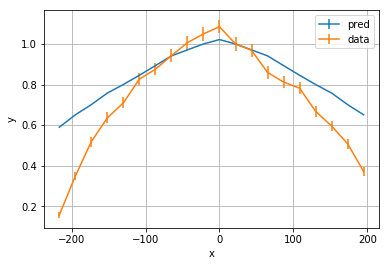

In [54]:
zero_solu = an.PoissonJeansSolve(0., 0., zRangeLarge)
zero_predict = an.fetchZPredict(zero_solu, zspaceMed, zspaceFull, wfunct, wspace, show_plot=False)
zero_SDPredict = [0. for k in range(len(starDensity_Delta))]
zero_predict_norm = zero_predict[int(np.ceil(len(zero_predict)/2.))]
zero_predict = zero_predict/zero_predict_norm
zero_predict_Delta = zero_SDPredict/zero_predict_norm
zero_likelihood = an.likelihoodDensity(zspaceFull, zero_predict, starDensity, zero_predict_Delta, starDensity_Delta, l_range_p, l_range_n, plot_dist = True)

HD_step = 10
SgmD_step = 2

for nHD in range(5,305,HD_step):
   param = an.diskParamReturn(0., nHD, 0.)
   interpx.append( float(param[1]) )
   interpy.append( float(param[0]) )
   interpxy.append( [float(param[1]),float(param[0])] )
   interpz.append( float(zero_likelihood) )

Now we do the same for the whole grid space in $(h_D, \Sigma_D)$, using a double for loop. The only difference is that since our method leads to our original guess $(h_D^{(\text{guess})}, \Sigma_D^{(\text{guess})})$ to be different from the actual $(h_D,\Sigma_D)$ after iteration, we need a function to extract the physical $(h_D,\Sigma_D)$.

- *diskParamReturn* : output a length = 2 list. The first entry is $h_D$ and the second is $\Sigma_D$, both directly calculated from "solu", the potential $\Phi(z)$.
    Arguments:
    - solu - scipy.interpolation.interp1d. The gravitational potential $\Phi(z)$.
    - nHD - float. Raw guess disk height $h_D$.
    - nSgmD - float. Raw guess disk surface density $\Sigma_D$.
    
This is all the difference.

As you can see in the commented-out line, bootstrap function allows us to extract prediction uncertainty (so dar we set it to *0*). It can be incorporated in the future.


In [24]:
SgmD_step = 2

for nHD in tqdm(range(5,305,HD_step)):
   for nSgmD in range(1,61,SgmD_step):
      solu = an.PoissonJeansSolve(nHD, nSgmD, zRangeLarge)
      param = an.diskParamReturn(solu, nHD, nSgmD)
    
      predict = an.fetchZPredict(solu, zspaceMed, zspaceFull, wfunct, wspace, show_plot=False)
      #SDPredict = an.bootstrap(predict,zspaceFull, nStars, nBootstrapSample)
      SDPredict = [0. for k in range(len(starDensity_Delta))]
      predict_norm = predict[int(np.ceil(len(predict)/2.))]
      predict = predict/predict_norm
      predict_Delta = SDPredict/predict_norm
    
      likelihood = an.likelihoodDensity(zspaceFull, predict, starDensity, predict_Delta, starDensity_Delta, l_range_p, l_range_n, plot_dist = False)
      interpx.append( float(param[1]) )
      interpy.append( float(param[0]) )
      interpxy.append( [float(param[1]),float(param[0])] )
      interpz.append( float(likelihood) )


100%|██████████| 30/30 [01:50<00:00,  3.67s/it]


## 2D interpolation and exclusion curve presentation

Now with the likelihood values ready, we generate our exclusion plot. Since after iteration our disk parameters $(h_D, \Sigma_D)$ shift, the original grid will no longer be rectangular. Nonetheless we keep track of the physical $(h_D, \Sigma_D)$ so this will not be a problem.

We set up a new rectangular grid "*spacex*" and "*spacey*" to prepare for 2D interpolation. the **griddata** function in *scipy.interpolation* is capable of interpolation with non-rectangular input data points.

In [25]:
spacex, spacey = np.mgrid[1:20:38j,0:100:25j]

f_likely = interp.griddata(np.array(interpxy), np.array(interpz), (spacex,spacey), method='nearest')

Now our data is in a rectangular grid of the parameter space of $\{h_D,\Sigma_D\}$. We maximize the log-likelihood ($\mathcal{L}$) with respect to $\Sigma_D$, along each $h_D$ strip and append into the list *opt_y_coord*. We define the relative log likelihood

<center>$\lambda = 2\big(\,\mathcal{L}(h_D,\Sigma_D)-\text{max}_{\Sigma_D}\mathcal{L}(h_D)\,\big)$.</center>

This quantity should behave like a chi-squared distribution. We can extract the 95% confident level given the number of degrees of freedom.

For some legacy reasons, we need to flip the x-, y-axes of the graph by tranposing the arrays. We can then compare with Fig. 2 of Schutz et. al. Saving the raw likelihood and the interpolated likelihood grids are options. 

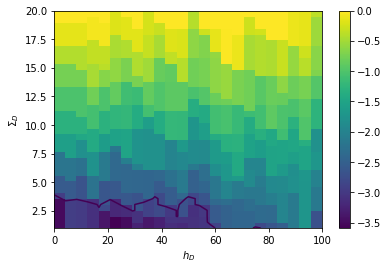

In [26]:
#cl_contour = [-3.841]
cl_contour = [-2.71]


outputx = spacex[:,0]
outputy = spacey[0,:]
outputz = np.array([])
opt_y_coord = np.array([])

for i, y in enumerate(outputy):
   peak_f = np.amax( f_likely[:,i] )
   opt_y_coord = np.append(opt_y_coord, peak_f)

plot_z = np.empty_like(f_likely)

for i, x in enumerate(outputx):
   for j, y in enumerate(outputy):
      plot_z[i,j] = 2.*(f_likely[i,j] - opt_y_coord[j])

spacex = np.transpose(spacex)
spacey = np.transpose(spacey)
plot_z = np.transpose(plot_z)
plt.pcolor(spacey, spacex, plot_z, vmin=plot_z.min(), vmax=plot_z.max())
plt.colorbar()
plt.contour(spacey, spacex, plot_z, cl_contour)
plt.xlabel('$h_D$')
plt.ylabel('$\Sigma_D$')
plt.show()

#with open(gridFile, 'a') as out_file:
#   for i,z in enumerate(outputz):
#      out_file.write(str(outputx[i]) + ', ' + str(outputy[i]) + ', ' + str(z) + '\n')

#with open(raw_gridFile, 'a') as out_file2:
#   for i,z in enumerate(interpz):
#      out_file2.write(str(interpx[i]) + ', ' + str(interpy[i]) + ', ' + str(z) + '\n')